In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [15]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [16]:
train = pd.read_csv('train3.csv')
test = pd.read_csv('test3.csv')

In [17]:
corr_mat = train.corr()

<Axes: >

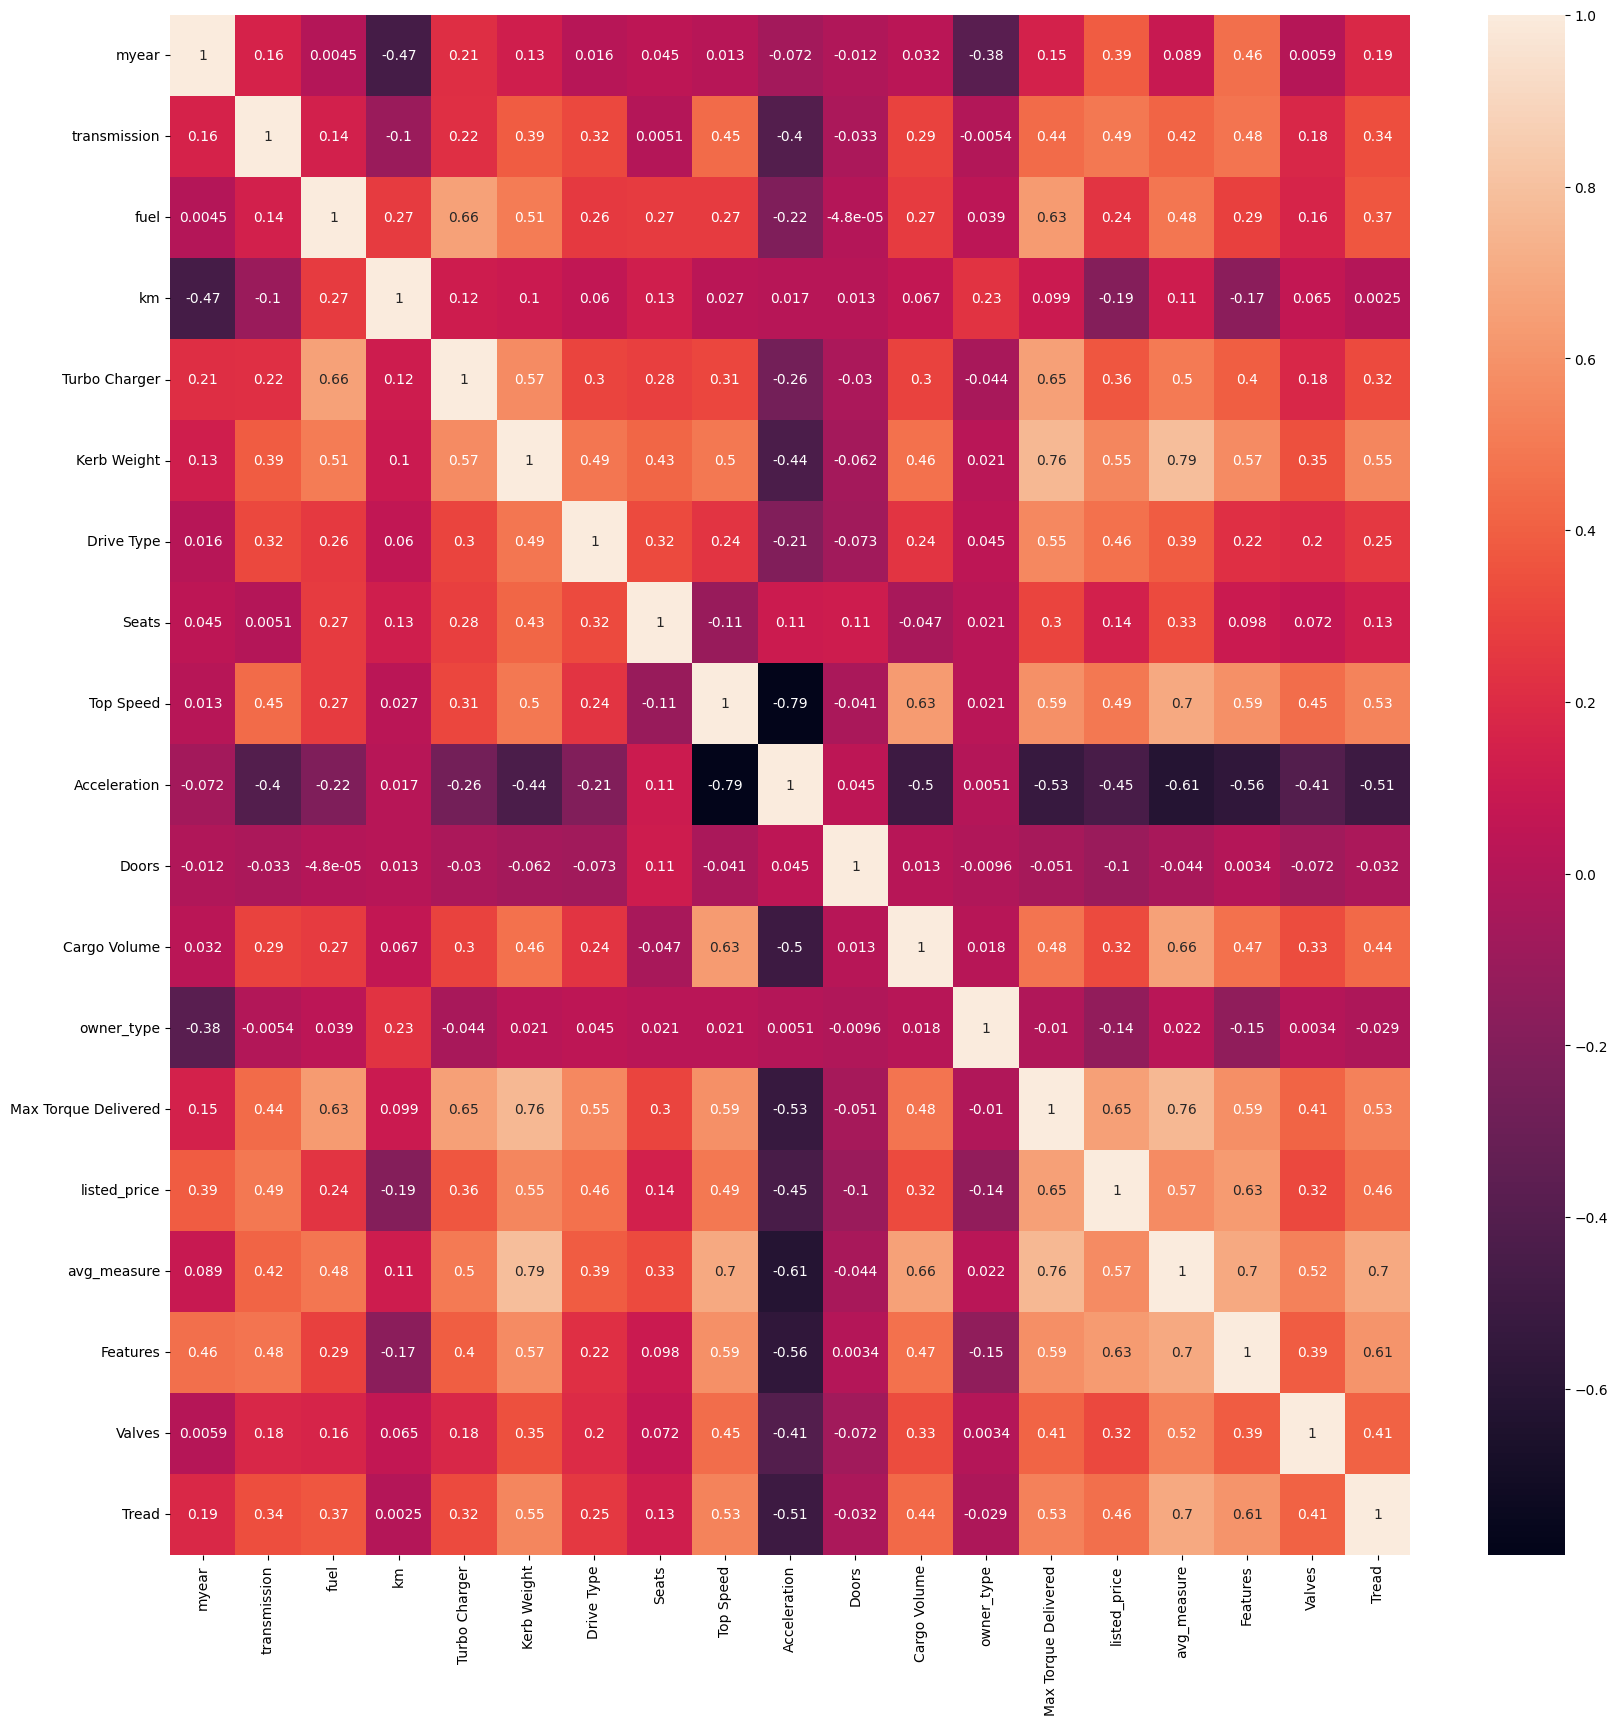

In [18]:
plt.figure(figsize = (20, 20))
sns.heatmap(corr_mat, annot = True)

In [19]:
df = pd.concat([train, test], axis = 0)
X = df.drop('listed_price', axis = 1)
y = df['listed_price']

In [20]:
#train_test_split
X_train = train.drop('listed_price', axis = 1)
X_test = test.drop('listed_price', axis = 1)
y_train = train['listed_price']
y_test = test['listed_price']

In [21]:
cat = CatBoostRegressor(verbose = False)

## 1. Predictions and evaluations

In [22]:
num_cols = [col for col in X_train.columns if X_train[col].dtype != 'O']
cat_cols = ['oem', 'body', 'Gear Box']
all_cols = num_cols + cat_cols

In [26]:
num_cols

['myear',
 'transmission',
 'fuel',
 'km',
 'Turbo Charger',
 'Kerb Weight',
 'Drive Type',
 'Seats',
 'Top Speed',
 'Acceleration',
 'Doors',
 'Cargo Volume',
 'owner_type',
 'Max Torque Delivered',
 'avg_measure',
 'Features',
 'Valves',
 'Tread']

In [23]:
def maepercent(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred) * 100 / y_true.mean()

In [30]:
def evaluate(model, X, X_train, X_test):
    model.fit(X_train, y_train, eval_set = (X_test, y_test))
    #model.randomized_search(params, X = X_train, y = y_train)
    testpreds = model.predict(X_test)
    trainpreds = model.predict(X_train)
    scoretest = mean_absolute_error(y_test, testpreds)
    scoretrain = mean_absolute_error(y_train, trainpreds)
    score_percenttest = scoretest * 100 / y_test.mean()
    score_percenttrain =  scoretrain * 100 / y_train.mean()
    
    print(f"for {model}")
    print("For train")
    print("MAE: ", scoretrain)
    print("MAE percent: ", score_percenttrain)
    print("=================================")
    print("For test")
    print("MAE: ", scoretest)
    print("MAE percent: ", score_percenttest)
    print("==================================")
    
    values = []
    percentages = []
    kf = KFold(n_splits = 5)
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[train_idx, :], X.iloc[val_idx, :]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr, eval_set = (X_val, y_val))
        preds = model.predict(X_val)
        
        mae = mean_absolute_error(y_val, preds)
        values.append(mae)
        maep = maepercent(y_val, preds)
        percentages.append(maep)
        
    for i in range(len(values)):
        print(f"for fold {i + 1}")
        print("MAE: ", values[i])
        print("MAE percent: ", percentages[i])
        print("============================")
    print("CV Summary: ")
    print(f"MAE: {np.mean(values):.2f} ±  {np.std(values):.2f}")
    print(f"MAE percent: {np.mean(percentages):.2f} ±  {np.std(percentages):.2f}")

num_cols =['myear',
 'transmission',
 'fuel',
 'km',
 #'Turbo Charger',
 'Kerb Weight',
 'Drive Type',
 #'Seats',
 'Top Speed',
 'Acceleration',
 #'Doors',
 'Cargo Volume',
 'owner_type',
 'Max Torque Delivered',
 'avg_measure',
 'Features',
 'Valves',
 'Tread',
 'body',
 'Gear Box']

In [31]:
%%time
evaluate(cat, X[num_cols], X_train[num_cols], X_test[num_cols])

for <catboost.core.CatBoostRegressor object at 0x00000247D277E190>
For train
MAE:  71888.13151591131
MAE percent:  10.028660250817707
For test
MAE:  98410.27685435746
MAE percent:  12.434797299698545
for fold 1
MAE:  86649.68452448871
MAE percent:  12.149119737901572
for fold 2
MAE:  87662.97108334815
MAE percent:  12.388401088584365
for fold 3
MAE:  86075.11186949791
MAE percent:  12.13118299826632
for fold 4
MAE:  85857.91416206022
MAE percent:  11.731652746597339
for fold 5
MAE:  91717.43248650164
MAE percent:  12.03146408402094
CV Summary: 
MAE: 87592.62 ±  2155.00
MAE percent: 12.09 ±  0.21
Wall time: 1min 17s


In [147]:
pd.concat([pd.Series(all_cols), pd.Series(cat.feature_importances_)], axis = 1)

,0,1
0,myear,24.718385
1,transmission,1.785058
2,fuel,1.890395
3,km,4.284342
4,Turbo Charger,0.017868
5,Kerb Weight,3.407494
6,Drive Type,2.867629
7,Seats,0.124795
8,Top Speed,2.143111
9,Acceleration,7.060968


In [120]:
params = {
        'iterations': list(range(100, 1000, 10)),
        'depth': list(range(4, 10)),
        'learning_rate': list(np.arange(0.01, 0.5)),
        'l2_leaf_reg': list(range(1, 100)),
        'early_stopping_rounds': list(range(4, 20))
    }

In [41]:
list(range(0, 5, 1))

[0, 1, 2, 3, 4]

## 2. HyperParam Optimisation

In [149]:
import optuna

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 100),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 4, 20)
    }

    model = CatBoostRegressor(verbose = False, **params)
    model.fit(X_train[all_cols], y_train, cat_features = cat_cols,
              eval_set=[(X_test[all_cols], y_test)], verbose=False)
    y_pred = model.predict(X_test[all_cols])
    mae = mean_absolute_error(y_test, y_pred)

    return mae
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 100)

print("Best hyperparameters:", study.best_params)
print("Best MAE:", study.best_value)
print("Best estimator: ", study.best_estimator)

In [46]:
catparams =  {'iterations': 768, 'depth': 8, 'learning_rate': 0.28426937133818087,
           'l2_leaf_reg': 10.624773837942582, 'early_stopping_rounds': 14}

In [52]:
%%time
opt_cat = CatBoostRegressor(**catparams, verbose = False)
evaluate(opt_cat, X[num_cols], X_train[num_cols], X_test[num_cols])

for <catboost.core.CatBoostRegressor object at 0x00000251EC3F9FD0>
For train
MAE:  61144.267455183515
MAE percent:  8.529851474265186
For test
MAE:  97989.33467787567
MAE percent:  12.381608437653258
for fold 1
MAE:  87005.48399604978
MAE percent:  12.002308104051234
for fold 2
MAE:  88291.0385334404
MAE percent:  12.179648898374312
for fold 3
MAE:  85123.3136411866
MAE percent:  11.742664832548888
for fold 4
MAE:  87265.5184126442
MAE percent:  12.038179557691619
for fold 5
MAE:  92955.70546989978
MAE percent:  12.823134425984366
CV Summary: 
MAE:  88128.21201064414  ±  2621.6551346519846
MAE percent:  12.157187163730084  ±  0.36165436043191984
Wall time: 1min 18s


In [107]:
#import pickle
#pickle_out = open('predictor.pkl', 'wb')
#pickle.dump(opt_cat, pickle_out)
#pickle_out.close()

In [20]:
num_cols

['myear',
 'transmission',
 'fuel',
 'km',
 'Turbo Charger',
 'Kerb Weight',
 'Drive Type',
 'Seats',
 'Top Speed',
 'Acceleration',
 'Doors',
 'Cargo Volume',
 'owner_type',
 'Max Torque Delivered',
 'avg_measure',
 'Features',
 'Valves',
 'Tread']

In [48]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
myear,31065.0,2015.350233,3.697186,2000.0,2013.000000,2016.000000,2018.000000,2023.00
transmission,31065.0,0.217125,0.412295,0.0,0.000000,0.000000,0.000000,1.00
fuel,31065.0,2.360309,0.567321,0.0,2.000000,2.000000,3.000000,4.00
km,31065.0,63985.117817,42545.629031,107.0,34246.000000,58917.000000,85081.000000,995000.00
Kerb Weight,31065.0,1178.389466,298.885650,600.0,942.867696,1100.000000,1491.285879,2962.00
Drive Type,31065.0,1.315886,0.803498,1.0,1.000000,1.000000,1.000000,4.00
Seats,31065.0,5.240270,0.660564,2.0,5.000000,5.000000,5.000000,7.00
Top Speed,31065.0,171.769214,22.018205,80.0,157.471212,169.000000,185.000000,285.00
Acceleration,31065.0,13.165254,2.737291,4.1,11.546351,12.930000,14.604886,44.04
Doors,31065.0,3.997682,0.068046,2.0,4.000000,4.000000,4.000000,4.00


In [54]:
opt_cat.predict([1999, 1, 3, 24000, True, 3400, 1100, 3, 135, 14,
                 5, 333, 2, 120, 2340, 60, 0, 1420])

1311414.827610363

In [87]:
a = pd.Series([2,3,5,4,3,5,3,2,4,3,5,4,4])
c = pd.Series([True, False , False, True])
b = a.mode()[0]
b

3

## 3. Error Analysis

In [153]:
cat_preds = pd.Series(cat.predict(X_test[all_cols]), name = 'predictions')
cat_residuals = pd.Series(np.abs(y_test - cat_preds), name = 'residuals')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


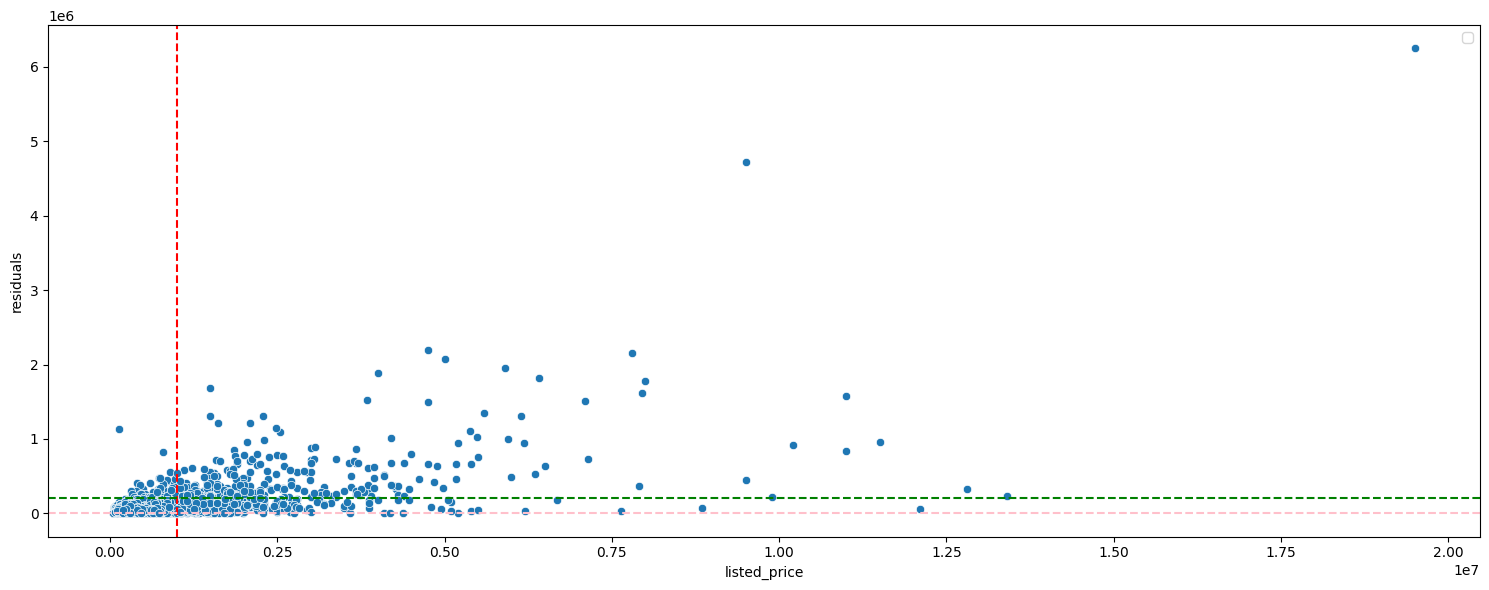

In [154]:
plt.figure(figsize = (15, 6))
sns.scatterplot(x = y_test, y = cat_residuals)
plt.axvline(x = 1000000, color = 'r', linestyle = '--')
plt.axhline(y = 200000, color = 'g', linestyle = '--')
plt.axhline(y = 0, color = 'pink', linestyle = '--')
plt.tight_layout()
plt.legend()

In [155]:
errors = pd.concat([y_test, cat_preds, cat_residuals, X_test['oem']], axis = 1)
game = errors.loc[errors.residuals > 150000]

<Axes: xlabel='residuals', ylabel='Count'>

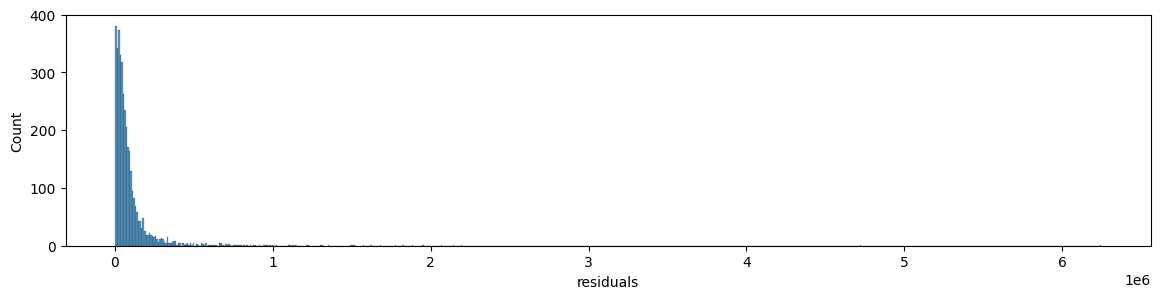

In [156]:
plt.figure(figsize = (14, 3))
sns.histplot(errors.residuals, fill = True)

In [157]:
errors.groupby('oem')['residuals'].agg([np.mean])

,mean
oem,
audi,3.423915e+05
bmw,4.241286e+05
chevrolet,3.597524e+04
datsun,3.621017e+04
fiat,4.631291e+04
ford,7.005211e+04
honda,6.568909e+04
hyundai,6.263294e+04
isuzu,1.175592e+05


In [158]:
mean_errors = errors.loc[errors.listed_price < 2000000].groupby('oem')['residuals'].agg([np.mean, max, min])

In [159]:
less_than_10l = errors.loc[errors.listed_price < 2000000]
counts = less_than_10l.oem.value_counts()

In [160]:
pd.concat([mean_errors, counts], axis = 1)

,mean,max,min,oem
audi,2.583120e+05,8.572201e+05,3.538404e+03,33
bmw,2.577348e+05,1.684754e+06,1.781973e+03,28
chevrolet,3.597524e+04,2.148474e+05,2.498990e+02,93
datsun,3.621017e+04,1.097281e+05,3.570692e+02,47
fiat,4.631291e+04,1.273531e+05,6.048636e+01,20
ford,5.748374e+04,1.943307e+05,1.498838e+03,106
honda,6.568909e+04,7.701853e+05,5.825831e+02,391
hyundai,6.143061e+04,1.130345e+06,2.024407e+02,734
isuzu,1.175592e+05,1.546961e+05,8.042228e+04,2
jaguar,2.248809e+05,2.306771e+05,2.190848e+05,2
